In [10]:
import numpy as np
import jax.numpy as jnp
import jax
import math

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial
from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, taylor_expand_2d, matching_coeffs

from utils.distribution_utils import construct_pdf, construct_cdf

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors


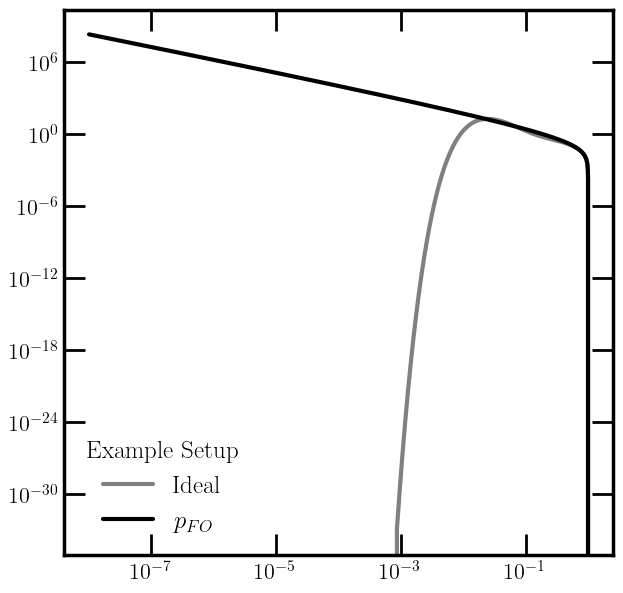

In [11]:

# Problem-dependent functions 
def t_from_x(x):
    return jnp.log(1/x)

def x_from_t(t):
    return jnp.exp(-t)


def p_ideal(t, alpha, params):
    alpha_bar = alpha #* 4/3 / jnp.pi
    return jnp.exp(-0.5 * alpha_bar * t**2 + 0.5 * alpha_bar**2 * t **4 - 0.5 * alpha_bar**3 * t**6) * (alpha_bar * t - 2 * alpha_bar**2 * t**3 + 3 * alpha_bar**3 * t**5)


# Taylor expansion of p(t| alpha) = exp(-alpha * t**2)(alpha * t)
def p_t(t, alpha, params):
    alpha_bar = alpha #* 4/3 / jnp.pi
    return alpha_bar * t #-  2.5 * alpha_bar**2 * t**3

p_x_ideal = lambda x, alpha, params: p_ideal(t_from_x(x), alpha, params) * jnp.abs(1/x)
p_x = lambda x, alpha, params: p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)

def p_x(x, alpha, params):
    return p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)


# Plot
xs = jnp.logspace(-8, 0, 10000)

fig, ax = newplot("full")
ax.plot(xs, p_x_ideal(xs, 0.118, None), label="Ideal", color = "grey")
ax.plot(xs, p_x(xs, 0.118, None), label=r"$p_{FO}$", color = "black")

ax.set_xscale("log")
ax.set_yscale("log")

plt.legend(title = "Example Setup")





In [12]:
def reduce_order(c_mn):

    M, N = c_mn.shape
    first_nonzero_m = 0
    for m in range(M):
        if np.any(c_mn[m, :] != 0):
            first_nonzero_m = m
            break

    first_nonzero_n = 0
    for n in range(N):
        if np.any(c_mn[:, n] != 0):
            first_nonzero_n = n
            break

    lowest_order_coeff = c_mn[first_nonzero_m, first_nonzero_n]

    return c_mn[first_nonzero_m:, first_nonzero_n:] / lowest_order_coeff, first_nonzero_m, first_nonzero_n, lowest_order_coeff


def log_match(c_mn, M, N):

    K = M + N

    polynomial_coeffs = polynomial_sum([polynomial_power(c_mn, k+1) / (k+1.0) for k in range(K+1)])
    return polynomial_coeffs[:M+1, :N+1]



In [13]:
M = 1
N = 1


def p_t(t, alpha, params):
    alpha_bar = alpha #* 4/3 / jnp.pi
    return alpha_bar * (1 - alpha_bar * t) 


# ########## Matching Algorithm ##########

def matching_coeffs(p_t, M, N):
 
    p_mn = taylor_expand_2d(p_t, 0.0, 0.0, M, N)
    P_mn = integrate_taylor_polynomial(p_mn)

    # print_polynomial(p_mn)
    # print_polynomial(P_mn)
    # print("")


    # Divide out the lowest order term of p_mn
    p_mn_reduced, m_star, n_star, p_star = reduce_order(p_mn)
    p_mn_reduced = p_mn_reduced.at[0, 0].set(0.0)

    p_matched = log_match(-p_mn_reduced, M - m_star, N-n_star)
    P_matched = log_match(P_mn, M, N) 

    # print("p_matched")
    # print_polynomial(p_matched)
    # print("P_matched")
    # print_polynomial(P_matched)
    # print("")


    g_mn = polynomial_sum([-p_matched, P_matched])
    g_star = jnp.zeros((M+1, N+1))
    g_star = g_star.at[m_star, n_star].set(-p_star)

    return g_mn[:,:N], g_star


# g_mn_matched, g_star = matching_coeffs(exponential_distribution, 1, 1)
# print(g_mn_matched)
# print(g_star)


In [14]:
def exponential_distribution(t, alpha, params):

    return alpha  * jnp.exp(-alpha * t)


def p_order_N(t, alpha, M):

    result = 0
    for i in range(M + 1):
        result += alpha  * jnp.power(-1 * alpha * t, i) / math.factorial(i)
    return result


vmapped_polynomial = jax.vmap(polynomial, in_axes=(0, None, None))


def f(t, alpha, g_star, g_mn):


    poly = polynomial(t, alpha, g_mn)
    g_star_poly = polynomial(t, alpha, g_star)
    return -1 * g_star_poly * jnp.exp( - poly)


vmapped_f = jax.vmap(f, in_axes=(0, None, None, None))

def integrate_f(t, alpha, g_star, g_mn):


    # Numerical integration
    ts = jnp.linspace(0, t, 1000)
    fs = vmapped_f(ts, alpha, g_star, g_mn)
    return jnp.trapz(fs, ts)


vmapped_integrate_f = jax.vmap(integrate_f, in_axes=(0, None, None, None))

@jax.jit
def q(t, alpha, g_star, g_mn):

    return vmapped_f(t, alpha, g_star, g_mn) * jnp.exp( -  vmapped_integrate_f(t, alpha, g_star, g_mn))


t = jnp.linspace(0, 20, 1000)




num_trials = 5
colors = []

factorials = np.zeros((8,8))
for i in range(factorials.shape[0]):
    for j in range(factorials.shape[1]):
        factorials[i, :] = math.factorial(i) * math.factorial(j)



data = np.zeros((5, t.shape[0], num_trials))

for order in range(5):



    for trial in range(num_trials):

        seed = jax.random.PRNGKey(trial)

        g_mn_matched, g_star = matching_coeffs(exponential_distribution, order, order)
        # print(g_mn_matched)
    
        
        g_mn = jax.random.normal(seed, factorials.shape)  / factorials / 10 
        g_mn = g_mn.at[:order+1, :].set(0)
        g_mn = g_mn.at[:order+1, :order].set(g_mn_matched)

        data[order, :, trial] = q(t, 0.118, g_star, g_mn)



/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:138: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)
/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:138: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)
/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:138: UserWarning: Explicitly requested dtype <class 'jax.

(0.9090909090909091, 1.1)

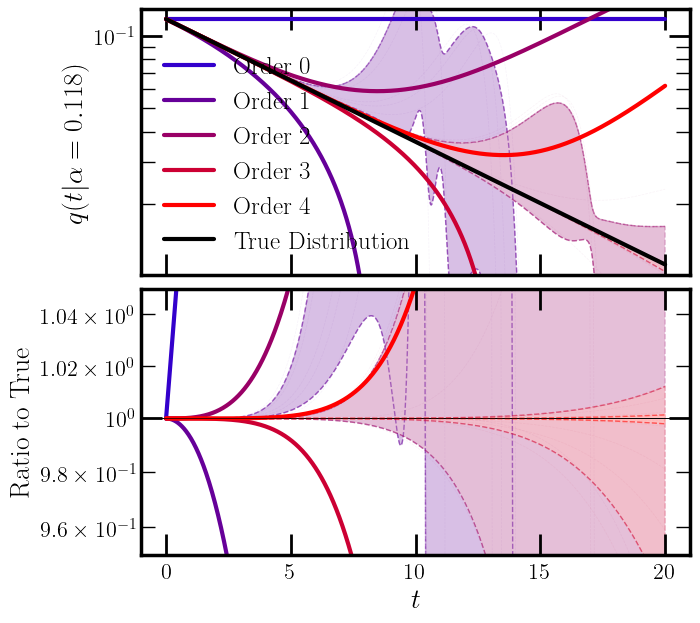

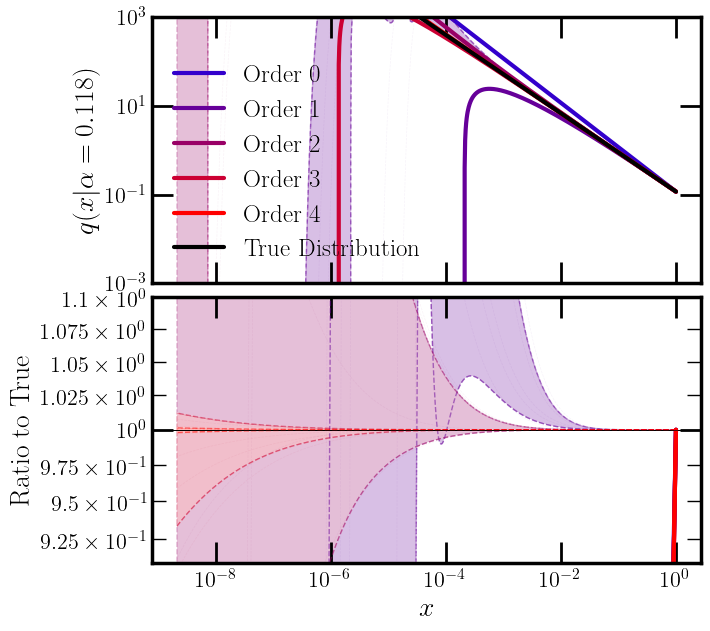

In [15]:
fig, ax = newplot("full", subplot_array=(2, 1), sharex=True)


for order in range(5):

    o = (order+1) / 5
    colors.append((o, 0, 1 - o))
    ax[0].plot(t, p_order_N(t, 0.118, order), label=f"Order {order}", color = colors[order],)



    for trial in range(num_trials):

        ax[0].plot(t, data[order, :,trial], color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)
        ax[1].plot(t, data[order, :,trial] / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)



    mean = np.nanmean(data[order], axis = 1)
    std = np.nanstd(data[order], axis = 1)

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax[0].plot(t, mean - std, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].plot(t, mean + std, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].fill_between(t, mean - std, mean + std, color = "white", alpha = 0.99, ls = "--")
    ax[0].fill_between(t, mean - std, mean + std, color = colors[order], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

    # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
    ax[1].plot(t, (mean - std) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].plot(t, (mean + std) / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].fill_between(t, (mean - std) / exponential_distribution(t, 0.118, None), (mean + std) / exponential_distribution(t, 0.118, None), color = "white", alpha = 0.99, ls = "--")
    ax[1].fill_between(t, (mean - std) / exponential_distribution(t, 0.118, None), (mean + std) / exponential_distribution(t, 0.118, None), color = colors[order], alpha = 0.25, ls = "--")
    

    ax[1].plot(t, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None), color = colors[order],)
    ax[1].axhline(1, color = "black", linestyle = "-", lw = 0.5)

ax[0].plot(t, exponential_distribution(t, 0.118, None), label="True Distribution", color = "Black")


ax[0].legend(loc = "lower left")

ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[1].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$q(t|\alpha = 0.118)$")
ax[1].set_ylabel("Ratio to True")

# Decrease margin between subplots
plt.subplots_adjust(hspace = 0.05)

max_y = 1.1 * np.max(exponential_distribution(t[1:], 0.118, None))
min_y = 0.9 * np.min(exponential_distribution(t[1:], 0.118, None))
ax[0].set_ylim(min_y, max_y)
ax[1].set_ylim(0.95, 1.05)






# ######################### X version #########################

fig, ax = newplot("full", subplot_array=(2, 1), sharex=True)

xs = x_from_t(t)

for order in range(5):

    o = (order+1) / 5
    colors.append((o, 0, 1 - o))
    ax[0].plot(xs, p_order_N(t, 0.118, order) / xs, label=f"Order {order}", color = colors[order],)



    for trial in range(num_trials):

        ax[0].plot(xs, data[order, :,trial] / xs , color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)
        ax[1].plot(xs, data[order, :,trial] / exponential_distribution(t, 0.118, None) , color = colors[order], linestyle = "--", alpha = 0.05, lw = 0.5)


    mean = np.nanmean(data[order], axis = 1) / xs
    std = np.nanstd(data[order], axis = 1) / xs

    # plt.plot(t, mean, color = colors[order], linestyle = "--", label = f"Order {order} Mean")
    ax[0].plot(xs, mean - std, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].plot(xs, mean + std, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[0].fill_between(xs, mean - std, mean + std, color = "white", alpha = 0.99, ls = "--")
    ax[0].fill_between(xs, mean - std, mean + std, color = colors[order], alpha = 0.25, ls = "--")
    # ax[0].plot(t, mean, color = colors[order], linestyle = "--")
    

    # ax[1].plot(t, mean / exponential_distribution(t, 0.118, None), color = colors[order], linestyle = "--")
    ax[1].plot(xs, (mean - std) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].plot(xs, (mean + std) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], linestyle = "--", alpha = 0.5, lw = 1)
    ax[1].fill_between(xs, (mean - std) / exponential_distribution(t, 0.118, None) * xs, (mean + std) / exponential_distribution(t, 0.118, None)* xs, color = "white", alpha = 0.99, ls = "--")
    ax[1].fill_between(xs, (mean - std) / exponential_distribution(t, 0.118, None)* xs, (mean + std) / exponential_distribution(t, 0.118, None)* xs, color = colors[order], alpha = 0.25, ls = "--")


    ax[1].plot(xs, p_order_N(t, 0.118, order) / exponential_distribution(t, 0.118, None)* xs, color = colors[order],)
    ax[1].axhline(1, color = "black", linestyle = "-", lw = 0.5)

ax[0].plot(xs, exponential_distribution(t, 0.118, None)/ xs, label="True Distribution", color = "Black")


ax[0].legend(loc = "lower left")

ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].set_xscale("log")

ax[1].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$q(x|\alpha = 0.118)$")
ax[1].set_ylabel("Ratio to True")

# Decrease margin between subplots
plt.subplots_adjust(hspace = 0.05)

ax[0].set_ylim(1e-3, 1e3)
ax[1].set_ylim(1/1.1, 1.1)

# Parameter Extraction

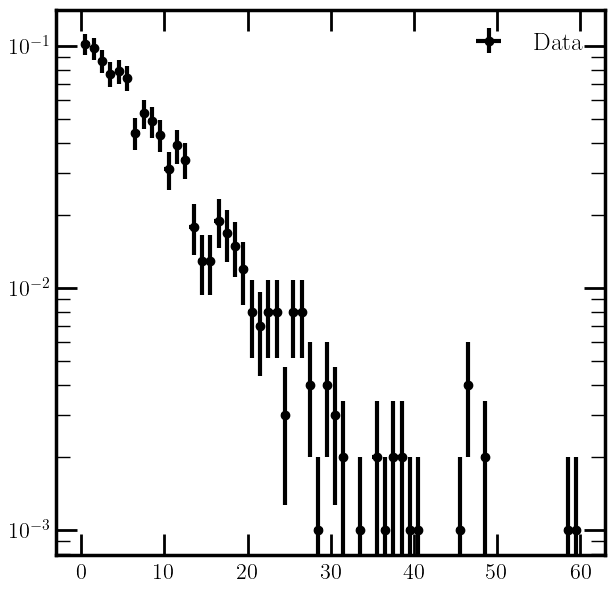

In [16]:
N_data = 1000
alpha_true = 0.118

# Sample an exponential distribution
seed = jax.random.PRNGKey(0)
t_data = jax.random.exponential(seed, (N_data,)) / alpha_true

fig, ax = newplot("full")
bins = 100
hist_with_errors(ax, t_data, bins = bins, range = [0, 100], label = "Data", color = "black", weights=np.ones_like(t_data)/N_data)
counts, bins = np.histogram(t_data, bins = 100, range = [0, 100], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2

plt.legend()

plt.yscale("log")

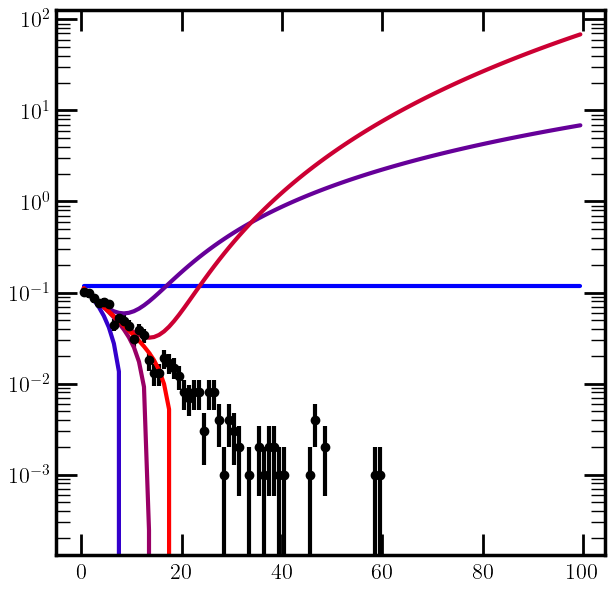

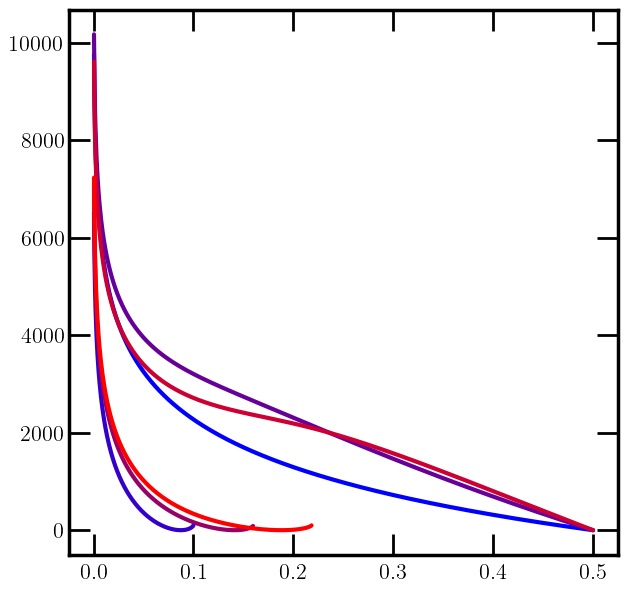

In [36]:
# Get lambda functions for FO likelihoods

def p_order_N(t, alpha, M):

    result = 0
    for i in range(M + 1):
        result += alpha  * jnp.power(-1 * alpha * t, i) / math.factorial(i)
    return result




max_M = 5


fig, ax = newplot("full")
bins = 100
hist_with_errors(ax, t_data, bins = bins, range = [0, 100], label = "Data", color = "black", weights=np.ones_like(t_data)/N_data)
counts, bins = np.histogram(t_data, bins = 100, range = [0, 100], density = True)
bin_centers = (bins[1:] + bins[:-1]) / 2

for i in range(max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    res = (lambda x : p_order_N(bin_centers, x, i))(0.118)
    ax.plot(bin_centers, res, label = f"Order {i}", color = color)
plt.yscale("log")



fig, ax = newplot("full")                                                                       
for i in range(max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)


    vmapped_p_order_N = jax.vmap(p_order_N, in_axes=(0, None, None))
    t_sorted = jnp.sort(t_data)
    t_sorted = t_sorted[t_sorted < 10]


    def likelihood_function(alpha):

        likelihoods = -2 * jnp.log(vmapped_p_order_N(t_sorted, alpha, i))
        cumulative_sum = jnp.cumsum(likelihoods)

        # return jnp.nanmin(cumulative_sum)
        return cumulative_sum[-1]
    


    vmapped_likelihood_function = jax.vmap(likelihood_function)
    alphas = jnp.linspace(0.00, 0.5, 1000)
    likelihoods = vmapped_likelihood_function(alphas)

    best_alpha = alphas[jnp.nanargmin(likelihoods, axis = 0)]  
    best_likelihood = likelihood_function(best_alpha)

    likelihoods = likelihoods - best_likelihood



    # best_alpha = alphas[jnp.argmin(likelihoods, axis = 0)]
    # ax.plot(t_sorted, best_alpha, label = f"Order {i}")
    
    ax.plot(alphas, likelihoods, label = f"Order {i}", color = color)



/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:138: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


Order 1
Min Alpha 0.12060241
Range 0.1168273 0.12429718
Order 2
Min Alpha 0.12060241
Range 0.1168273 0.12429718
Order 3
Min Alpha 0.12060241
Range 0.1168273 0.124538146
Order 4
Min Alpha 0.12036145
Range 0.11666667 0.12421686
Order 5
Min Alpha 0.1224498
Range 0.11803213 0.12598394


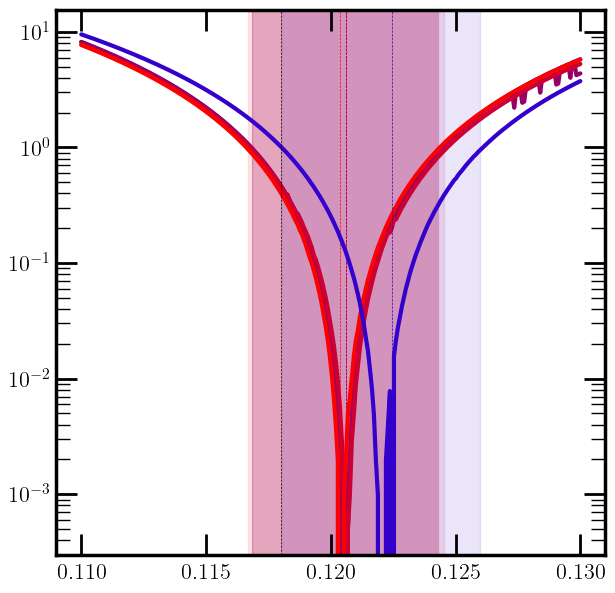

In [94]:
from scipy.optimize import minimize


num_higher_orders = 1

max_M = 5

fig, ax = newplot("full")                                                                       
for i in range(1,max_M + 1):

    color = (i / max_M, 0, 1 - i / max_M)

    
    g_mn_matched, g_star = matching_coeffs(exponential_distribution, i, i)
    g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
    # print(g_mn_matched.shape)
    # print(g_mn.shape)
    # print(i+1, i)

    g_mn = g_mn.at[:i+1, :i].set(g_mn_matched)

    # We can only change parameters after the matched order in alpha
    non_frozen_params_mask = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders), dtype = bool)
    non_frozen_params_mask = non_frozen_params_mask.at[i+1:, :].set(True)


    @jax.jit
    def likelihood_function(params):

        alpha = params[0]
        g_mn_higher = params[1:]

        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))

        # print("")
        # print(g_mn_matched.shape)
        # print(g_mn.shape)
        # print(g_mn_higher.shape)

        g_mn = g_mn.at[:i+1, :i].set(g_mn_matched)
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        return -2 * jnp.sum(jnp.log(q(t_data, alpha, g_star, g_mn)))
    
    @jax.jit
    def profile_likelihood_function(g_mn_higher, alpha):

        g_mn = jnp.zeros((g_mn_matched.shape[0]+num_higher_orders, g_mn_matched.shape[1]+num_higher_orders))
        g_mn = g_mn.at[:i+1, :i].set(g_mn_matched)
        g_mn = g_mn.at[i+1:, :].set(g_mn_higher)

        return -2 * jnp.sum(jnp.log(q(t_data, alpha, g_star, g_mn)))
    

    # Minimize likelihood function
    initial_alpha = 0.12
    initial_guess = jnp.zeros(g_mn.shape[1]+1)

    initial_guess = initial_guess.at[0].set(initial_alpha)


    res_full = minimize(likelihood_function, initial_guess, method='Nelder-Mead', options={'disp': False})

    alphas = jnp.linspace(0.11, 0.13, 250)

    def profile_minimize(alphas):
        res_partial = minimize(profile_likelihood_function, res_full.x[1:], args=(alphas), method='Nelder-Mead', options={'disp': False})
        return res_partial.fun

    likelihoods = jnp.zeros(alphas.shape)
    for j, alpha in enumerate(alphas):
        res_partial = profile_minimize(alpha)
        likelihoods = likelihoods.at[j].set(res_partial)

    likelihoods = likelihoods - res_full.fun

    ax.plot(alphas, likelihoods, label = f"Order {i}", color = colors[i])

    # Get the alphas where the likelihood is within 1 of the minimum
    min_alpha = alphas[jnp.argmin(likelihoods[:-1])]
    ax.axvline(min_alpha, linestyle = "--", lw = 0.5, color = colors[i])

    where_less_than_one = jnp.where(likelihoods < 1)
    alphas_less_than_one = alphas[where_less_than_one]



    minus_one = alphas_less_than_one[0]
    plus_one = alphas_less_than_one[-2]

    # Vertical band
    ax.axvspan(minus_one, plus_one, alpha=0.1, color=colors[i])

    print("Order", i)
    print("Min Alpha", min_alpha)
    print("Range", minus_one, plus_one)

    
    # vmapped_likelihood_function = jax.vmap(likelihood_function)
    # alphas = jnp.linspace(0.00, 1.0, 100)
    # likelihoods = vmapped_likelihood_function(alphas)
    

    # min_alpha = alphas[jnp.argmin(likelihoods)]

    # ax.plot(alphas, likelihoods, label = f"Order {i}", color = f"C{i}")
    # ax.axvline(min_alpha, linestyle = "--", lw = 0.5, color = f"C{i}")

ax.axvline(0.118, linestyle = "--", lw = 0.5, color = "black")

plt.yscale("log")

<function jax._src.scipy.optimize.minimize.minimize(fun: Callable, x0: jax.Array, args: Tuple = (), *, method: str, tol: Union[float, NoneType] = None, options: Union[Mapping[str, Any], NoneType] = None) -> jax._src.scipy.optimize.minimize.OptimizeResults>